**Note:** run `details.ipynb`, `process-dataset.py` and `conv2d-prepare.py` before starting this notebook.

In [1]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")

# Disable GPU - high RAM usage
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print(f"GPU devices: {tf.config.list_physical_devices('GPU')}")

TensorFlow version: 2.10.1
Keras version: 2.10.0
GPU devices: []


In [2]:
if os.path.exists('config/localconfig.py'):
    from config import localconfig as config
else:
    from config import config

In [3]:
target_paths = os.listdir(config.BB_OBJECTS)

import random
random.shuffle(target_paths)

images, targets = [], []

In [4]:
import numpy as np
import pickle

with open("dataset.pkl", "rb") as f:
    data = pickle.load(f)

(x_train), (y_train) = (
    np.asarray(data['X'][: int(len(data['X']) * 0.8)]),
    np.asarray(data['y'][: int(len(data['y']) * 0.8)]).astype('uint8'),
)
(x_test), (y_test) = (
    np.asarray(data['X'][int(len(data['X']) * 0.8) :]),
    np.asarray(data['y'][int(len(data['y']) * 0.8) :]).astype('uint8'),
)

classes = data['classes']
del data

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (19965, 224, 224, 3) - y_train shape: (19965,)
x_test shape: (4992, 224, 224, 3) - y_test shape: (4992,)


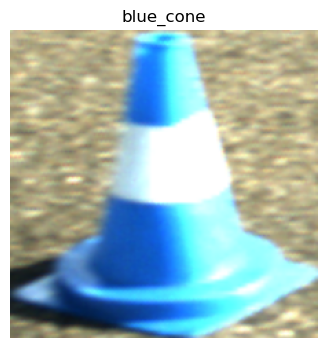

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
plt.imshow(x_train[0].astype("uint8"))
plt.title(classes[y_train[0]])
plt.axis("off")
plt.show()

In [6]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(5, activation='softmax'))

model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=10e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

In [7]:
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                      patience=5,
                                      min_delta=0.1,
                                      verbose=1)

history = model.fit(x_train,
                    y_train,
                    epochs=100,
                    validation_split=0.1,
                    callbacks=[es])

Epoch 1/100
562/562 [==============================] - 158s 279ms/step - loss: 0.6720 - sparse_categorical_accuracy: 0.9343 - val_loss: 0.1616 - val_sparse_categorical_accuracy: 0.9514
Epoch 2/100
562/562 [==============================] - 160s 284ms/step - loss: 0.1735 - sparse_categorical_accuracy: 0.9656 - val_loss: 0.1809 - val_sparse_categorical_accuracy: 0.9589
Epoch 3/100
562/562 [==============================] - 158s 281ms/step - loss: 0.1312 - sparse_categorical_accuracy: 0.9721 - val_loss: 0.2603 - val_sparse_categorical_accuracy: 0.9459
Epoch 4/100
562/562 [==============================] - 154s 275ms/step - loss: 0.1101 - sparse_categorical_accuracy: 0.9752 - val_loss: 0.4467 - val_sparse_categorical_accuracy: 0.9299
Epoch 5/100
562/562 [==============================] - 152s 271ms/step - loss: 0.1182 - sparse_categorical_accuracy: 0.9768 - val_loss: 0.2433 - val_sparse_categorical_accuracy: 0.9659
Epoch 6/100
562/562 [==============================] - 152s 270ms/step - lo

In [8]:
test_loss, test_acc = model.evaluate(x_test, y_test)

156/156 [==============================] - 12s 74ms/step - loss: 0.2741 - sparse_categorical_accuracy: 0.9700


In [9]:
model.save(os.path.join("models", f"conv2d_loss_{round(test_loss, 2)}_acc_{round(test_acc, 2)}.h5"), save_format="h5")

In [10]:
y_pred = model.predict(x_test)
pred_class = np.argmax(y_pred, axis=-1)
print(pred_class[:10])
print(y_test[:10])

156/156 [==============================] - 9s 55ms/step
[2 2 2 2 2 2 1 1 1 1]
[2 2 2 2 2 2 1 1 1 1]


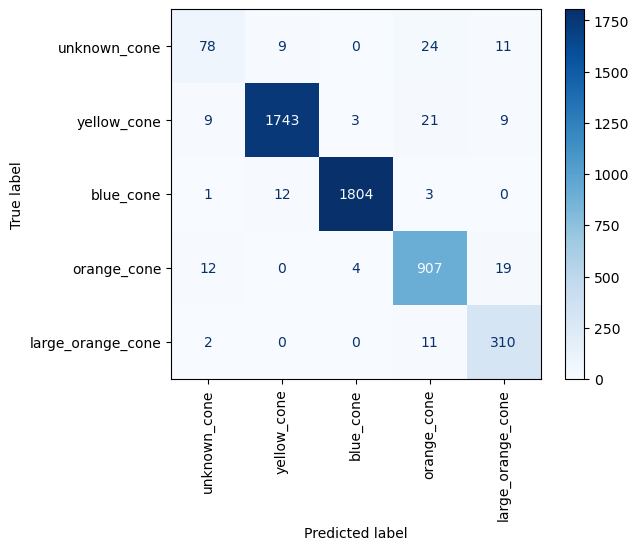

In [11]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, pred_class, cmap="Blues", display_labels=classes, xticks_rotation='vertical')